# Sales Forecasting using Time Series Analysis (Prophet)

## Project: Retail Sales AI & Analytics Pipeline

### Objective
The objective of this notebook is to forecast future monthly sales revenue using historical retail sales data.  
The forecasting model is built using Facebook Prophet after aggregating transactional data at a monthly level using SQL.

### Key Steps
- Load cleaned and aggregated sales data
- Prepare time series data for forecasting
- Train Prophet time series model
- Generate 12-month sales forecast
- Compare actual vs predicted values
- Produce insights for business decision-making

### Tools & Technologies
- Python (Pandas, NumPy)
- Prophet (Time Series Forecasting)
- Matplotlib (Visualization)
- SQL (Data preparation – previous phase)

# 1. IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


# 2. LOAD DATA

In [2]:
import os

# Ensure the directory exists
os.makedirs("../data", exist_ok=True)

# 1️⃣ Load data
df = pd.read_csv("../data/retail_sales.csv", encoding="latin1")

print(df.shape)
display(df.head())

# 2️⃣ Convert ORDERDATE to datetime (important!)
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], errors='coerce')

# 3️⃣ Create Year-Month column
df['YEARMONTH'] = df['ORDERDATE'].dt.to_period('M').dt.to_timestamp()

# 4️⃣ Aggregate monthly sales (USE 'SALES')
monthly_sales = (
    df.groupby('YEARMONTH')['SALES']
    .sum()
    .reset_index()
)

# 5️⃣ Rename columns for Prophet
monthly_sales.columns = ['ds', 'y']

display(monthly_sales.head())

# 6️⃣ Save processed file
monthly_sales.to_csv(
    "../data/monthly_sales.csv",
    index=False
)

print("monthly_sales.csv saved successfully")


(2823, 25)


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


,ds,y
0,2003-01-01,129753.60
1,2003-02-01,140836.19
2,2003-03-01,174504.90
3,2003-04-01,201609.55
4,2003-05-01,192673.11


monthly_sales.csv saved successfully


# 3. DATE CLEANING

In [3]:
# Convert ORDERDATE to datetime
df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")

# Drop rows with invalid dates
df = df.dropna(subset=["ORDERDATE"])

# 4. MONTHLY SALES AGGREGATION

In [4]:
monthly_sales = (
    df.groupby(df["ORDERDATE"].dt.to_period("M"))["SALES"]
    .sum()
    .reset_index()
)

monthly_sales["ORDERDATE"] = monthly_sales["ORDERDATE"].dt.to_timestamp()

monthly_sales.columns = ["ds", "y"]

monthly_sales.head()

,ds,y
0,2003-01-01,129753.60
1,2003-02-01,140836.19
2,2003-03-01,174504.90
3,2003-04-01,201609.55
4,2003-05-01,192673.11


# 5. HISTORICAL TREND VISUALIZATION

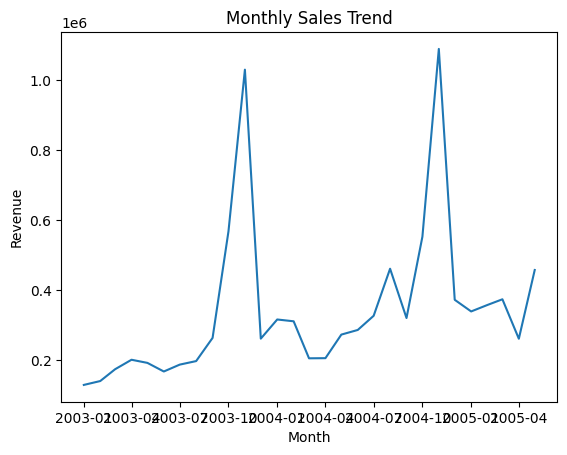

In [5]:
plt.figure()
plt.plot(monthly_sales["ds"], monthly_sales["y"])
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()

# 6. TRAIN PROPHET MODEL

In [6]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

model.fit(monthly_sales)

22:34:15 - cmdstanpy - INFO - Chain [1] start processing
22:34:15 - cmdstanpy - INFO - Chain [1] done processing


# 7. FUTURE FORECAST SALES (NEXT 12 MONTHS)

In [7]:
future = model.make_future_dataframe(periods=12, freq='ME')
forecast = model.predict(future)

print("\nForecast Output:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


Forecast Output:
           ds           yhat     yhat_lower     yhat_upper
36 2005-12-31  452507.083561  417123.309008  487024.183002
37 2006-01-31  425317.601876  389869.910378  461946.657980
38 2006-02-28  448900.501856  412263.638467  486795.967234
39 2006-03-31  540660.337071  504124.124227  575203.008240
40 2006-04-30  488332.321286  452156.715366  520499.915051


# 8. FORECAST VISUALIZATION

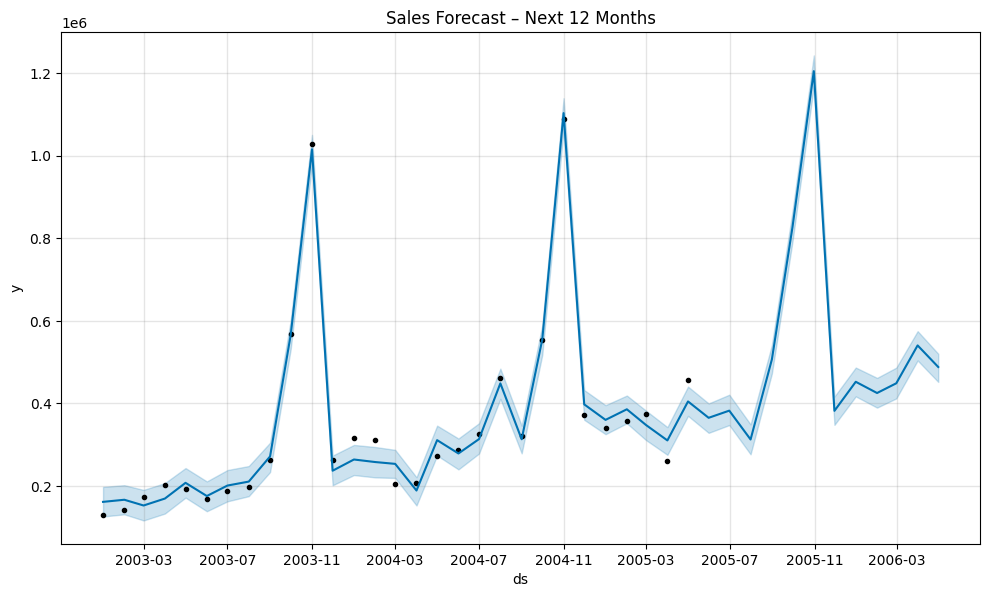

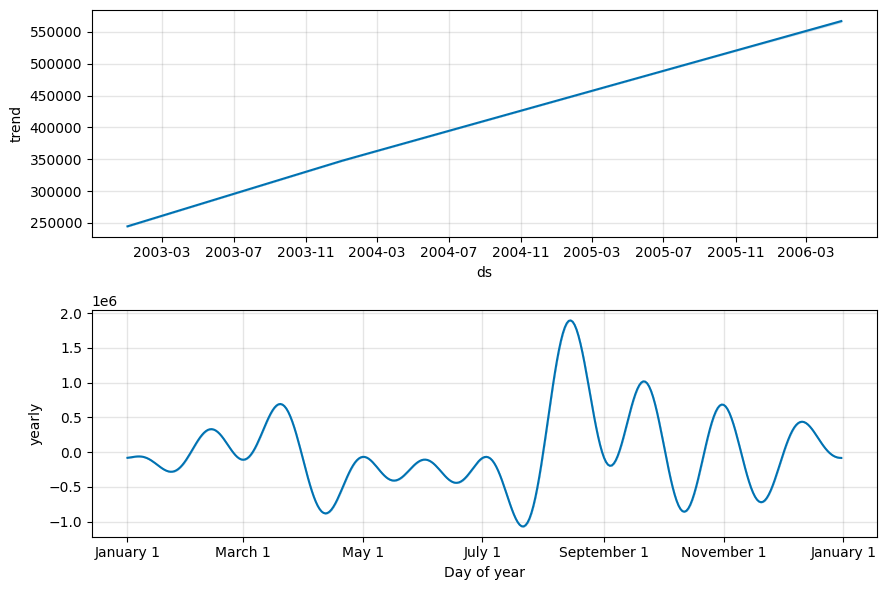

In [8]:
model.plot(forecast)
plt.title("Sales Forecast – Next 12 Months")
plt.show()

model.plot_components(forecast)
plt.show()

# 9. MODEL EVALUATION

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

merged = pd.merge(
    monthly_sales,
    forecast[["ds", "yhat"]],
    on="ds",
    how="inner"
)

mae = mean_absolute_error(merged["y"], merged["yhat"])
rmse = np.sqrt(mean_squared_error(merged["y"], merged["yhat"]))

print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))

MAE: 23366.08
RMSE: 27964.19


In [10]:
monthly_sales.head()

,ds,y
0,2003-01-01,129753.60
1,2003-02-01,140836.19
2,2003-03-01,174504.90
3,2003-04-01,201609.55
4,2003-05-01,192673.11


# 10. SAVE FORECAST

In [11]:
forecast_output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_output.to_csv("../data/sales_forecast.csv", index=False)

# 11. BUSINESS INSIGHTS

In [12]:
print("\nBUSINESS INSIGHTS:")
print("- Sales show clear yearly seasonality.")
print("- Forecast predicts steady revenue growth.")
print("- Peak months indicate inventory planning opportunities.")
print("- Model useful for demand forecasting and revenue strategy.")


BUSINESS INSIGHTS:
- Sales show clear yearly seasonality.
- Forecast predicts steady revenue growth.
- Peak months indicate inventory planning opportunities.
- Model useful for demand forecasting and revenue strategy.
